In [1]:
%run ./Text_Normalization_Function.ipynb #defining text normalization function

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangweichao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yangweichao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yangweichao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yangweichao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

In [2]:
import numpy as np
import pandas as pd
import nltk
from sklearn import metrics
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def get_topic_words(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_words = []
    for topic_weights in lda_model.components_:
        top_word_locs = (-topic_weights).argsort()[:n_words]
        topic_words.append(keywords.take(top_word_locs).tolist())
    return topic_words

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [4]:
df = pd.read_excel('/Users/yangweichao/Desktop/DAT562 Text Mining/Final/Ford_data.xlsx')
df.head()

,class,text
0,Pos,Some of you might have read my previous post ...
1,Pos,I bought my new 1999 Ford Taurus just two mon...
2,Pos,My first car was a Ford One of those old cl...
3,Pos,Last spring we got a new car a 1999 ford tau...
4,Pos,Recently I bought a used 99 Ford Taurus The...


In [5]:
df_Pos=df[df['class'].isin(['Pos'])]
df_Pos.head()

,class,text
0,Pos,Some of you might have read my previous post ...
1,Pos,I bought my new 1999 Ford Taurus just two mon...
2,Pos,My first car was a Ford One of those old cl...
3,Pos,Last spring we got a new car a 1999 ford tau...
4,Pos,Recently I bought a used 99 Ford Taurus The...


In [6]:
df_Neg=df[df['class'].isin(['Neg'])]
df_Neg.head()

,class,text
345,Neg,In 1992 we bought a new Taurus and we really ...
346,Neg,The last business trip I drove to San Franci...
347,Neg,My husband and I purchased a 1990 Ford F250 a...
348,Neg,I feel I have a thorough opinion of this truc...
349,Neg,AS a mother of 3 all of whom are still in ca...


In [8]:
data = [go.Bar(
            x = df['class'].unique(),
            y = df['class'].value_counts().values,
            marker= dict(color = df['class'].value_counts().values),
            text='Text entries attributed to class')]

layout = go.Layout(title='Label distribution')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [9]:
all_words = df_Pos['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[10:50],
            y = all_words.values[10:50],
            marker= dict(colorscale='Jet',color = all_words.values[10:100]))]

layout = go.Layout(title='Top 50 (Uncleaned) Word frequencies in the Pos dataset')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [10]:
all_words = df_Neg['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[10:50],
            y = all_words.values[10:50],
            marker= dict(colorscale='Jet',color = all_words.values[10:100]))]

layout = go.Layout(title='Top 50 (Uncleaned) Word frequencies in the Neg dataset')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

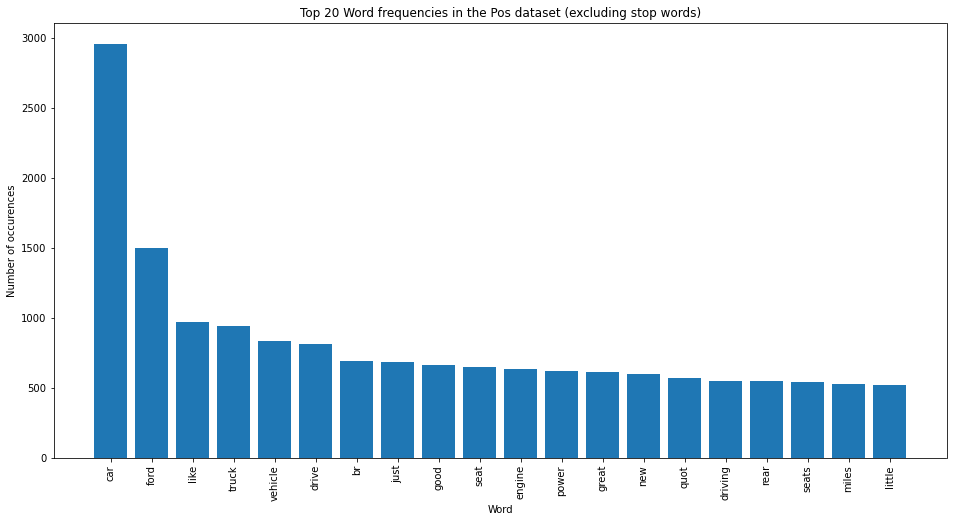

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=20,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_Pos['text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 20 Word frequencies in the Pos dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

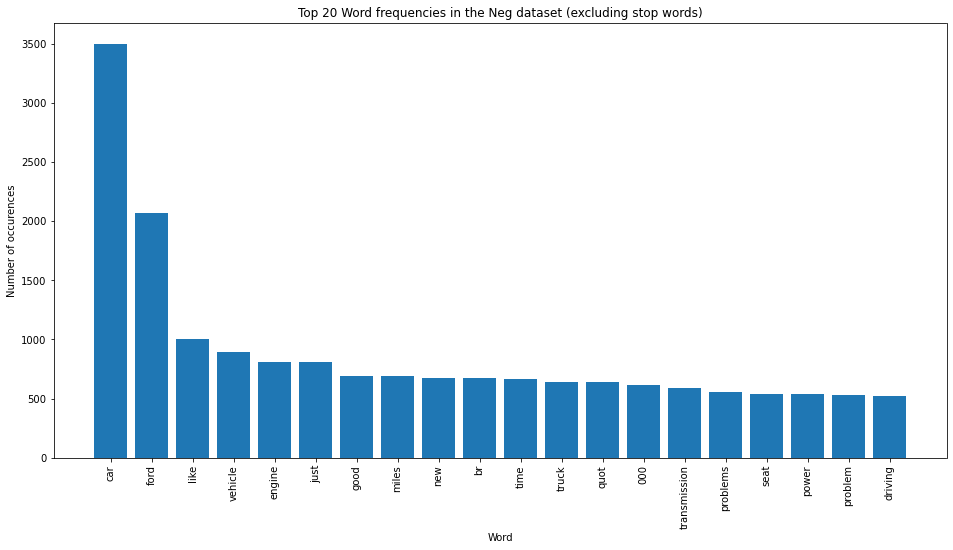

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=20,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_Neg['text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 20 Word frequencies in the Neg dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

**Positive Label Topic Modeling**

In [13]:
normalized_Pos = normalize_corpus(df_Pos['text'])

bow_vectorizer_Pos = CountVectorizer(max_features=1000)

bow_corpus_Pos = bow_vectorizer_Pos.fit_transform(normalized_Pos)

In [14]:
lda_Pos = LatentDirichletAllocation(n_components=2, max_iter=100,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [15]:
lda_Pos.fit(bow_corpus_Pos)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=100, n_components=2, random_state=0)

In [16]:
no_top_words_Pos = 20
display_topics(lda_Pos, bow_vectorizer_Pos.get_feature_names(), no_top_words_Pos)

Topic 0:
car drive ford like br buy look good problem mile great vehicle quot year well new gas time seat want
Topic 1:
seat truck ford rear vehicle drive wheel control front power like well door engine model good driver look suv side


In [17]:
word_weights_Pos= lda_Pos.components_ / lda_Pos.components_.sum(axis=1)[:, np.newaxis]
word_weights_df_Pos = pd.DataFrame(word_weights_Pos.T, 
                               index = bow_vectorizer_Pos.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(2)])
word_weights_df_Pos.head()

,Topic_0,Topic_1
0l,0.000192,0.000523
146s,0.000009,0.002179
146t,0.000009,0.001476
146ve,0.000009,0.000662
3rd,0.000040,0.000429


In [18]:
word_weights_df_Pos.sort_values(by='Topic_0',ascending=False).head(10)

,Topic_0,Topic_1
car,0.055282,0.005185
drive,0.017827,0.009370
ford,0.013896,0.015743
like,0.011057,0.007733
br,0.010334,0.000457
buy,0.010270,0.000874
look,0.009939,0.005978
good,0.009922,0.006096
problem,0.008960,0.001019
mile,0.008773,0.000620


In [19]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_Pos, bow_corpus_Pos, bow_vectorizer_Pos, mds='tsne')

/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  57.263349
1      60.312561 -141.369141       2        1  42.736651, topic_info=         Term         Freq        Total Category  logprob  loglift
133       car  3592.000000  3592.000000  Default  30.0000  30.0000
915     truck  1015.000000  1015.000000  Default  29.0000  29.0000
110        br   648.000000   648.000000  Default  28.0000  28.0000
754      seat  1221.000000  1221.000000  Default  27.0000  27.0000
700      rear   545.000000   545.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
369      good   276.322978   878.929279   Topic2  -5.1001  -0.3070
498      look   270.979583   874.608854   Topic2  -5.1196  -0.3216
302  explorer   208.774240   400.643590   Topic2  -5.3804   0.1983
933       use   220.047495   521.125933   Topic2  -5.3278  -0.0120
133       car   235.015400  3592.578534   Topic2  -5.2620  -1.8769

[185 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.010071   146s
1         2  0.997064   146s
2         1  0.014819   146t
2         2  0.992905   146t
3         1  0.032703  146ve
...     ...       ...    ...
991       2  0.987495     xl
993       1  0.770290   year
993       2  0.230108   year
998       1  0.999418    zx2
998       2  0.012188    zx2

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [20]:
lda_Pos_topic_weights = lda_Pos.transform(bow_corpus_Pos)
Pos_doc_names = ["Doc_" + str(i) for i in range(len(normalized_Pos))]
Pos_topic_names = ["Topic_" + str(i) for i in range(2)]
df_Pos_document_topic = pd.DataFrame(np.round(lda_Pos_topic_weights, 4), columns=Pos_topic_names, index=Pos_doc_names)
df_Pos_document_topic.head()

,Topic_0,Topic_1
Doc_0,0.9686,0.0314
Doc_1,0.8783,0.1217
Doc_2,0.7882,0.2118
Doc_3,0.9886,0.0114
Doc_4,0.5529,0.4471


In [21]:
Pos_dominant_topic = np.argmax(df_Pos_document_topic.values, axis=1)
df_Pos_document_topic['Pos_dominant_topic'] = Pos_dominant_topic
df_Pos_document_topic.head(10)

,Topic_0,Topic_1,Pos_dominant_topic
Doc_0,0.9686,0.0314,0
Doc_1,0.8783,0.1217,0
Doc_2,0.7882,0.2118,0
Doc_3,0.9886,0.0114,0
Doc_4,0.5529,0.4471,0
Doc_5,0.9890,0.0110,0
Doc_6,0.3609,0.6391,1
Doc_7,0.5223,0.4777,0
Doc_8,0.5262,0.4738,0
Doc_9,0.4398,0.5602,1


In [22]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

Pos_corpus_tokenized = [tokenize_text(normalized_Pos[doc_id]) for doc_id in range(len(normalized_Pos))]
Pos_dictionary = Dictionary(Pos_corpus_tokenized)
Pos_corpus_bow = [Pos_dictionary.doc2bow(doc) for doc in Pos_corpus_tokenized]
Pos_topic_topwords = get_topic_words(vectorizer = bow_vectorizer_Pos, lda_model = lda_Pos, n_words=20)

In [23]:
cm_Pos = CoherenceModel(topics=Pos_topic_topwords, 
                    corpus = Pos_corpus_bow , 
                    dictionary = Pos_dictionary, coherence='u_mass')
print("Coherence score for the model (higher values are better): ", np.round(cm_Pos.get_coherence(), 5))
print("Coherence score by topic (higher values are better): ", np.round(cm_Pos.get_coherence_per_topic(),5))
print("Log-Likelihood (higher values are better): ", lda_Pos.score(bow_corpus_Pos))
print("Perplexity (lower values are better): ", lda_Pos.perplexity(bow_corpus_Pos))

Coherence score for the model (higher values are better):  -0.73658
Coherence score by topic (higher values are better):  [-0.69924 -0.77391]
Log-Likelihood (higher values are better):  -669225.9580643387
Perplexity (lower values are better):  549.8812404565177


**Negative Label Topic Modeling**

In [24]:
normalized_Neg = normalize_corpus(df_Neg['text'])

bow_vectorizer_Neg = CountVectorizer(max_features=1000)

bow_corpus_Neg = bow_vectorizer_Neg.fit_transform(normalized_Neg)

In [25]:
lda_Neg = LatentDirichletAllocation(n_components=2, max_iter=100,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [26]:
lda_Neg.fit(bow_corpus_Neg)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=100, n_components=2, random_state=0)

In [27]:
no_top_words_Neg = 20
display_topics(lda_Neg, bow_vectorizer_Neg.get_feature_names(), no_top_words_Neg)

Topic 0:
car ford problem time buy mile drive vehicle br quot replace year new take transmission work repair first month truck
Topic 1:
car seat like ford drive good look engine vehicle well power rear much even front model use door road little


In [28]:
word_weights_Neg = lda_Neg.components_ / lda_Neg.components_.sum(axis=1)[:, np.newaxis]
word_weights_df_Neg = pd.DataFrame(word_weights_Neg.T, 
                               index = bow_vectorizer_Neg.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(2)])
word_weights_df_Neg.head()

,Topic_0,Topic_1
146s,0.000009,0.000620
146t,0.000009,0.000417
2nd,0.000126,0.000639
3rd,0.000084,0.000823
4wd,0.000099,0.000477


In [29]:
word_weights_df_Neg.sort_values(by='Topic_0',ascending=False).head(10)

,Topic_0,Topic_1
car,0.041996,0.029586
ford,0.024765,0.012432
problem,0.017171,0.001776
time,0.012816,0.003428
buy,0.011555,0.002701
mile,0.011091,0.002257
drive,0.010209,0.011495
vehicle,0.010020,0.008151
br,0.009493,0.002582
quot,0.008861,0.002786


In [30]:
pyLDAvis.sklearn.prepare(lda_Neg, bow_corpus_Neg, bow_vectorizer_Neg, mds='tsne')

/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yangweichao/opt/anaconda3/lib/python3.9/site-

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  52.790936
0      60.312561 -141.369141       2        1  47.209064, topic_info=        Term         Freq        Total Category  logprob  loglift
663  problem  1040.000000  1040.000000  Default  30.0000  30.0000
752     seat  1078.000000  1078.000000  Default  29.0000  29.0000
717  replace   481.000000   481.000000  Default  28.0000  28.0000
716   repair   382.000000   382.000000  Default  27.0000  27.0000
328      fix   354.000000   354.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
915    truck   351.950573   645.781674   Topic2  -5.0390   0.1436
263   engine   335.899628   848.873767   Topic2  -5.0857  -0.1765
447     know   275.587565   412.715046   Topic2  -5.2836   0.3467
476     like   311.476087  1110.834007   Topic2  -5.1612  -0.5210
364     good   277.025508   914.672897   Topic2  -5.2784  -0.4439

[181 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         1  0.995130          146s
11        1  0.976668  acceleration
11        2  0.018782  acceleration
18        1  0.994012      adequate
18        2  0.021609      adequate
...     ...       ...           ...
979       2  0.972599        winter
988       1  0.189382          work
988       2  0.810475          work
996       1  0.320271          year
996       2  0.679670          year

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [31]:
lda_Neg_topic_weights = lda_Neg.transform(bow_corpus_Neg)
Neg_doc_names = ["Doc_" + str(i) for i in range(len(normalized_Neg))]
Neg_topic_names = ["Topic_" + str(i) for i in range(2)]
df_Neg_document_topic = pd.DataFrame(np.round(lda_Neg_topic_weights, 4), columns=Neg_topic_names, index=Neg_doc_names)
df_Neg_document_topic.head()

,Topic_0,Topic_1
Doc_0,0.3686,0.6314
Doc_1,0.0776,0.9224
Doc_2,0.9953,0.0047
Doc_3,0.6511,0.3489
Doc_4,0.5300,0.4700


In [32]:
Neg_dominant_topic = np.argmax(df_Neg_document_topic.values, axis=1)
df_Neg_document_topic['Neg_dominant_topic'] =Neg_dominant_topic
df_Neg_document_topic.head()

,Topic_0,Topic_1,Neg_dominant_topic
Doc_0,0.3686,0.6314,1
Doc_1,0.0776,0.9224,1
Doc_2,0.9953,0.0047,0
Doc_3,0.6511,0.3489,0
Doc_4,0.5300,0.4700,0


In [33]:
Neg_corpus_tokenized = [tokenize_text(normalized_Neg[doc_id]) for doc_id in range(len(normalized_Neg))]
Neg_dictionary = Dictionary(Neg_corpus_tokenized)
Neg_corpus_bow = [Neg_dictionary.doc2bow(doc) for doc in Neg_corpus_tokenized]
Neg_topic_topwords = get_topic_words(vectorizer = bow_vectorizer_Neg, lda_model = lda_Neg, n_words=20)

In [34]:
cm_Neg = CoherenceModel(topics=Neg_topic_topwords, 
                    corpus = Neg_corpus_bow , 
                    dictionary = Neg_dictionary, coherence='u_mass')
print("Coherence score for the model (higher values are better): ", np.round(cm_Neg.get_coherence(), 5))
print("Coherence score by topic (higher values are better): ", np.round(cm_Neg.get_coherence_per_topic(),5))
print("Log-Likelihood (higher values are better): ", lda_Neg.score(bow_corpus_Neg))
print("Perplexity (lower values are better): ", lda_Neg.perplexity(bow_corpus_Neg))

Coherence score for the model (higher values are better):  -0.81841
Coherence score by topic (higher values are better):  [-0.84783 -0.78898]
Log-Likelihood (higher values are better):  -723462.3433573309
Perplexity (lower values are better):  538.2068038721801
